### Aim:
In this notebook, the effect of combining three best-performing models (logistic regression, SVM, and Decision Tree) for "mostDILI" predictions via a voting classifier will be evaluated.

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [220]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read in datasets, prepare data for ML

In [221]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [222]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [223]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [224]:
## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=45)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=45)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=45)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

True

True

### Voting Classifier - 
#### based on logistic regression and SVM and Decision Tree (three best performing algorithms) with optimized parameters for each algorithm

In [225]:
#Instantiate voting classifier based on optimal parameters for logistic and SVM models

log_mc=LogisticRegression(class_weight='balanced')
log_tc=LogisticRegression(class_weight='balanced')
log_mctc=LogisticRegression(class_weight='balanced')


svm_mc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=2, random_state = 1)
svm_tc = SVC(kernel='linear',probability=True, class_weight='balanced', gamma=1e-06,C=1, random_state = 1)
svm_mctc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=0.5, random_state = 1)

dt_mc = tree.DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_split=0.1)
dt_tc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=0.1)
dt_mctc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=0.1)


vot_clf_mc=VotingClassifier(estimators=[('log_mc', log_mc), ('svm_mc', svm_mc), ('dt_mc', dt_mc)], voting='soft', weights=[1,0.2, .15])
vot_clf_tc=VotingClassifier(estimators=[('log_tc', log_tc), ('svm_tc', svm_tc), ('dt_tc', dt_tc)], voting='soft', weights=[1,0.2, .15])
vot_clf_mctc=VotingClassifier(estimators=[('log_mctc', log_mctc), ('svm_mctc', svm_mctc), ('dt_mctc', dt_mctc)], voting='soft', weights=[1,0.2, .15])

In [226]:
#Fit to instntiated voting classifiers

vot_clf_mc.fit(train_mcx, train_mcy)
vot_clf_tc.fit(train_tcx, train_tcy)
vot_clf_mctc.fit(train_mctcx, train_mctcy)

VotingClassifier(estimators=[('log_mc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('sv...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.2, 0.15])

VotingClassifier(estimators=[('log_tc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('sv...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.2, 0.15])

VotingClassifier(estimators=[('log_mctc', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 0.2, 0.15])

In [227]:
#Predict test_y values and probabilities for each dataset based on voting classifiers model from above

#Using voting classifier model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
vot_clf_pred_mcy=vot_clf_mc.predict(test_mcx) 
vot_clf_probs_mcy=vot_clf_mc.predict_proba(test_mcx) 

### Using voting classifier model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
vot_clf_pred_tcy=vot_clf_tc.predict(test_tcx) 
vot_clf_probs_tcy=vot_clf_tc.predict_proba(test_tcx) 


### Using voting classifier model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
vot_clf_pred_mctcy=vot_clf_mctc.predict(test_mctcx) 
vot_clf_probs_mctcy=vot_clf_mctc.predict_proba(test_mctcx) 

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Performance metrics of voting classifier models fitted on test-train splits

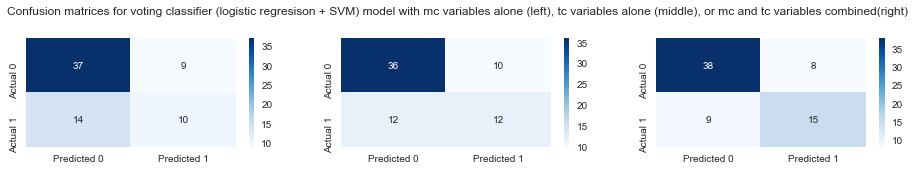

In [228]:
### Confusion Matrix
vot_clf_cfm_mc=metrics.confusion_matrix(test_mcy, vot_clf_pred_mcy)
vot_clf_cfm_tc=metrics.confusion_matrix(test_tcy, vot_clf_pred_tcy)
vot_clf_cfm_mctc=metrics.confusion_matrix(test_mctcy, vot_clf_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(vot_clf_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(vot_clf_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(vot_clf_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for voting classifier (logistic regresison + SVM) model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [229]:
### Precision, Recall
vot_clf_cr_mc=metrics.classification_report(test_mcy, vot_clf_pred_mcy)
vot_clf_cr_tc=metrics.classification_report(test_tcy, vot_clf_pred_tcy)
vot_clf_cr_mctc=metrics.classification_report(test_mctcy, vot_clf_pred_mctcy)
print("precision_recall for model with mc variables alone")
print(vot_clf_cr_mc)
print("precision_recall for model with tc variables alone")
print(vot_clf_cr_tc)
print("precision_recall for model with mc&tc variables combined")
print(vot_clf_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.73      0.80      0.76        46
          1       0.53      0.42      0.47        24

avg / total       0.66      0.67      0.66        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.75      0.78      0.77        46
          1       0.55      0.50      0.52        24

avg / total       0.68      0.69      0.68        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.81      0.83      0.82        46
          1       0.65      0.62      0.64        24

avg / total       0.75      0.76      0.76        70



#### Roc curve analysis

In [230]:
#calculate values to populate ROC curve

vot_clf_fpr_mc,vot_clf_tpr_mc, vot_clf_thresholds_mc=roc_curve(test_mcy, vot_clf_probs_mcy[:, 1])
vot_clf_roc_auc_mc=metrics.auc(vot_clf_fpr_mc, vot_clf_tpr_mc)

vot_clf_fpr_tc,vot_clf_tpr_tc, vot_clf_thresholds_tc=roc_curve(test_tcy, vot_clf_probs_tcy[:, 1])
vot_clf_roc_auc_tc=metrics.auc(vot_clf_fpr_tc, vot_clf_tpr_tc)

vot_clf_fpr_mctc,vot_clf_tpr_mctc, vot_clf_thresholds_mctc=roc_curve(test_mctcy, vot_clf_probs_mctcy[:,1])
vot_clf_roc_auc_mctc=metrics.auc(vot_clf_fpr_mctc, vot_clf_tpr_mctc)

#Calculate values to populate precision-recall curve
from sklearn.metrics import precision_recall_curve

vot_clf_precision_mc, vot_clf_recall_mc, vot_clf_thresholds_mc = precision_recall_curve(test_mcy, vot_clf_probs_mcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_mc = metrics.auc(vot_clf_recall_mc, vot_clf_precision_mc)

vot_clf_precision_tc, vot_clf_recall_tc, vot_clf_thresholds_tc = precision_recall_curve(test_tcy, vot_clf_probs_tcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_tc = metrics.auc(vot_clf_recall_tc, vot_clf_precision_tc)

vot_clf_precision_mctc, vot_clf_recall_mctc, vot_clf_thresholds_mctc = precision_recall_curve(test_mctcy, vot_clf_probs_mctcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
vot_clf_pr_auc_mctc = metrics.auc(vot_clf_recall_mctc, vot_clf_precision_mctc)

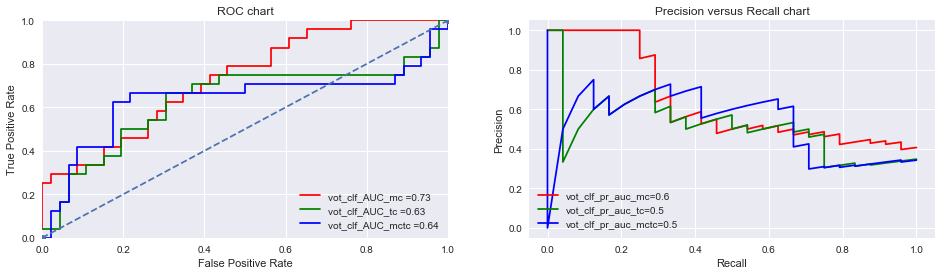

In [231]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(vot_clf_fpr_mc, vot_clf_tpr_mc, 'r', label='vot_clf_AUC_mc =%0.2f'% vot_clf_roc_auc_mc)
plt.plot(vot_clf_fpr_tc, vot_clf_tpr_tc, 'g', label='vot_clf_AUC_tc =%0.2f'% vot_clf_roc_auc_tc)
plt.plot(vot_clf_fpr_mctc, vot_clf_tpr_mctc, 'b', label='vot_clf_AUC_mctc =%0.2f'% vot_clf_roc_auc_mctc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(vot_clf_recall_mc, vot_clf_precision_mc, "r", label = 'vot_clf_pr_auc_mc=%.1f' % (vot_clf_pr_auc_mc))
plt.plot(vot_clf_recall_tc, vot_clf_precision_tc, "g", label = 'vot_clf_pr_auc_tc=%.1f' % (vot_clf_pr_auc_tc))
plt.plot(vot_clf_recall_mctc, vot_clf_precision_mctc, "b", label = 'vot_clf_pr_auc_mctc=%.1f' % (vot_clf_pr_auc_mctc))
plt.legend(loc='lower left')
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.show();

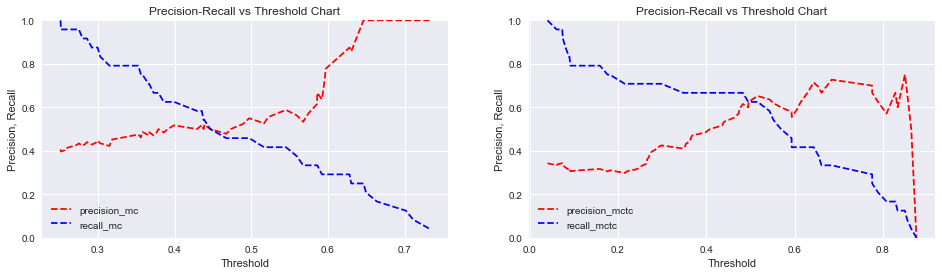

In [232]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(vot_clf_thresholds_mc, vot_clf_precision_mc[: -1], "r--", label="precision_mc")
plt.plot(vot_clf_thresholds_mc, vot_clf_recall_mc[: -1], "b--", label="recall_mc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


axes = fig.add_subplot(122)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(vot_clf_thresholds_mctc, vot_clf_precision_mctc[: -1], "r--", label="precision_mctc")
plt.plot(vot_clf_thresholds_mctc, vot_clf_recall_mctc[: -1], "b--", label="recall_mctc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


plt.show();

### Conclusion:

When incorporating decision trees into fused logistic regression/SVM models, there are modest benefits (slight increase in precision/sensitivity of class '0') at the cost of lower performance with detection of "mostDILI" drugs.

Based on this, there is no appreciable net-benefit to adding decision trees to the mix.
    